<a href="https://colab.research.google.com/github/frozoni/frozoni/blob/main/Notebook_Simulador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **IMPORT E LIBS utilizadas**

In [2]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=71e26ae6295f3bd34cadbb05ad3fa786678d5a5912a0341c2ab7863b8badf630
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [3]:
  pip install pandera

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.8.0 which is incompatible.


In [4]:
# Importando as bibliotecas necessárias
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr
from pyspark.sql.window import Window
from cryptography.fernet import Fernet
spark = SparkSession.builder.getOrCreate()
import csv
import pandas as pd
import pandera as pa
import xlrd

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


# **BASE CEP**

In [5]:
# Lendo o arquivo CSV
base_cep = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Base_Case/BaseCEP.csv", sep=',')

In [6]:
base_cep

,CEP|Estado|Região
0,20125535|Mato Grosso|Centro - Oeste
1,25995770|Rio Grande do Norte|Nordeste
2,37278465|Sergipe|Nordeste
3,49897703|Mato Grosso|Centro - Oeste
4,30149335|Mato Grosso|Centro - Oeste
...,...
855,801388803|Bahia|Nordeste
856,131504555|Acre|Norte
857,560973100|Roraima|Norte
858,233130568|Alagoas|Nordeste


In [8]:
# Substituição de separador e remoção de colunas vazias
dados = []
with open('/content/drive/MyDrive/Colab Notebooks/Base_Case/BaseCEP.csv', 'r', encoding='utf-8-sig') as file:
    reader = csv.reader(file, delimiter='|')
    for row in reader:
      if '' not in row:
        cleaned_row = [cell.replace('||', '|') for cell in row]
        dados.append(cleaned_row)

base_cep_tratato = pd.DataFrame(dados[1:], columns=dados[0])

In [9]:
#Save arquivo tratado
base_cep_tratato.to_csv('/content/drive/MyDrive/Colab Notebooks/Base_Case/BaseCEP_tratado.csv', index = False)
base_cep_tratato

,CEP,Estado,Região
0,20125535,Mato Grosso,Centro - Oeste
1,25995770,Rio Grande do Norte,Nordeste
2,37278465,Sergipe,Nordeste
3,49897703,Mato Grosso,Centro - Oeste
4,30149335,Mato Grosso,Centro - Oeste
...,...,...,...
830,801388803,Bahia,Nordeste
831,131504555,Acre,Norte
832,560973100,Roraima,Norte
833,233130568,Alagoas,Nordeste


# **BASE CARGOS**

In [10]:
# Lendo o arquivo CSV
base_cargos = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Base_Case/BaseCargos.csv", sep=';', header=True, inferSchema=True)
base_cargos.show()

+-----+-----------+--------------+---------+---------+--------+--------+-----------+
|Cargo|      Nível|          Área| COD Área|COD Nível|  Quadro|   Bonus|Contratacao|
+-----+-----------+--------------+---------+---------+--------+--------+-----------+
|  OPV|    Diretor|     Operações|      JAJ|       JE| Efetivo|       S|  Diretoria|
|  LOI| Estagiário|     Logísitca|      EDE|       JA| Efetivo|       N|    Gerente|
|  ADI| Estagiário|Administrativo|      BAC|       JA| Efetivo|       N|    Gerente|
| ADII|   Analista|Administrativo|      BAC|       DB|Terceiro|       N|         RH|
| OPII|   Analista|     Operações|      JAJ|       DB|Terceiro|       N|         RH|
|  FIV|    Diretor|    Financeiro|      CBB|       JE| Efetivo|       S|  Diretoria|
| FIII|   Analista|    Financeiro|      CBB|       DB|Terceiro|       N|         RH|
|ADIII|Coordenador|Administrativo|      BAC|       DB|Terceiro|       N|         RH|
| LOIV|       NULL|       Gerente|Logísitca|      EDE|      ID| E

In [11]:
# Converter para PANDAS
base_cargos_pandas = base_cargos.toPandas()
base_cargos_pandas

,Cargo,Nível,Área,COD Área,COD Nível,Quadro,Bonus,Contratacao
0,OPV,Diretor,Operações,JAJ,JE,Efetivo,S,Diretoria
1,LOI,Estagiário,Logísitca,EDE,JA,Efetivo,N,Gerente
2,ADI,Estagiário,Administrativo,BAC,JA,Efetivo,N,Gerente
3,ADII,Analista,Administrativo,BAC,DB,Terceiro,N,RH
4,OPII,Analista,Operações,JAJ,DB,Terceiro,N,RH
5,FIV,Diretor,Financeiro,CBB,JE,Efetivo,S,Diretoria
6,FIII,Analista,Financeiro,CBB,DB,Terceiro,N,RH
7,ADIII,Coordenador,Administrativo,BAC,DB,Terceiro,N,RH
8,LOIV,None,Gerente,Logísitca,EDE,ID,Efetivo,S
9,FII,Estagiário,Financeiro,CBB,JA,Efetivo,N,Gerente


In [12]:
# Deslocamaneto de dados das colunas
base_cargos_tratado = base_cargos_pandas
cargos = base_cargos_tratado["Cargo"]

base_cargos_tratado = base_cargos_tratado.drop(["Cargo"], axis=1)
base_cargos_tratado.loc[base_cargos_tratado["Nível"].isna()] = base_cargos_tratado.loc[base_cargos_tratado["Nível"].isna()].shift(periods=-1,axis="columns")

base_cargos_tratado.insert(0, "Cargo", cargos)

In [13]:
base_cargos_tratado

,Cargo,Nível,Área,COD Área,COD Nível,Quadro,Bonus,Contratacao
0,OPV,Diretor,Operações,JAJ,JE,Efetivo,S,Diretoria
1,LOI,Estagiário,Logísitca,EDE,JA,Efetivo,N,Gerente
2,ADI,Estagiário,Administrativo,BAC,JA,Efetivo,N,Gerente
3,ADII,Analista,Administrativo,BAC,DB,Terceiro,N,RH
4,OPII,Analista,Operações,JAJ,DB,Terceiro,N,RH
5,FIV,Diretor,Financeiro,CBB,JE,Efetivo,S,Diretoria
6,FIII,Analista,Financeiro,CBB,DB,Terceiro,N,RH
7,ADIII,Coordenador,Administrativo,BAC,DB,Terceiro,N,RH
8,LOIV,Gerente,Logísitca,EDE,ID,Efetivo,S,None
9,FII,Estagiário,Financeiro,CBB,JA,Efetivo,N,Gerente


In [14]:
# Renomeando as colunas
base_cargos_tratado = base_cargos_tratado.rename(columns={'Nível': 'Nivel', 'Área': 'Area','COD Área': 'Cod_Area','COD Nível':'Cod_Nivel'})
base_cargos_tratado

,Cargo,Nivel,Area,Cod_Area,Cod_Nivel,Quadro,Bonus,Contratacao
0,OPV,Diretor,Operações,JAJ,JE,Efetivo,S,Diretoria
1,LOI,Estagiário,Logísitca,EDE,JA,Efetivo,N,Gerente
2,ADI,Estagiário,Administrativo,BAC,JA,Efetivo,N,Gerente
3,ADII,Analista,Administrativo,BAC,DB,Terceiro,N,RH
4,OPII,Analista,Operações,JAJ,DB,Terceiro,N,RH
5,FIV,Diretor,Financeiro,CBB,JE,Efetivo,S,Diretoria
6,FIII,Analista,Financeiro,CBB,DB,Terceiro,N,RH
7,ADIII,Coordenador,Administrativo,BAC,DB,Terceiro,N,RH
8,LOIV,Gerente,Logísitca,EDE,ID,Efetivo,S,None
9,FII,Estagiário,Financeiro,CBB,JA,Efetivo,N,Gerente


In [15]:
# Substituir os valores na coluna "Area"
base_cargos_tratado['Area'] = base_cargos_tratado['Area'].replace({'Logísitca': 'Logística', '@@@Operações': 'Operações'})
base_cargos_tratado

,Cargo,Nivel,Area,Cod_Area,Cod_Nivel,Quadro,Bonus,Contratacao
0,OPV,Diretor,Operações,JAJ,JE,Efetivo,S,Diretoria
1,LOI,Estagiário,Logística,EDE,JA,Efetivo,N,Gerente
2,ADI,Estagiário,Administrativo,BAC,JA,Efetivo,N,Gerente
3,ADII,Analista,Administrativo,BAC,DB,Terceiro,N,RH
4,OPII,Analista,Operações,JAJ,DB,Terceiro,N,RH
5,FIV,Diretor,Financeiro,CBB,JE,Efetivo,S,Diretoria
6,FIII,Analista,Financeiro,CBB,DB,Terceiro,N,RH
7,ADIII,Coordenador,Administrativo,BAC,DB,Terceiro,N,RH
8,LOIV,Gerente,Logística,EDE,ID,Efetivo,S,None
9,FII,Estagiário,Financeiro,CBB,JA,Efetivo,N,Gerente


In [16]:
#Save arquivo tratado
base_cargos_tratado.to_csv('/content/drive/MyDrive/Colab Notebooks/Base_Case/BaseCargos_tratado.csv', index = False)

# **BASE CLIENTES**

In [17]:
# Lendo o arquivo CSV
base_clientes = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Base_Case/BaseClientes.csv", sep=';', header=True, inferSchema=True)
base_clientes.show()

+-------------------+--------------------+----------------------+-----------------+---------+--------------------+--------------------+----+----+----+----+----+
|            Cliente|Valor Contrato Anual|Quantidade de Serviços|Cargo Responsável|      CEP|Data Início Contrato|Nivel de Importancia| _c7| _c8| _c9|_c10|_c11|
+-------------------+--------------------+----------------------+-----------------+---------+--------------------+--------------------+----+----+----+----+----+
| Teixeira Gonçalves|               54000|                    37|            ADIII|743419711|          15/03/2019|                   3|NULL|NULL|NULL|NULL|NULL|
|       Souza Santos|              126000|                    12|             FIIV|882467283|          08/04/2019|                   1|NULL|NULL|NULL|NULL|NULL|
|       Emídio Alves|              319500|                    23|             ADII|295150983|          09/02/2019|                   3|NULL|NULL|NULL|NULL|NULL|
|       Santos Costa|             

In [18]:
# Converter para PANDAS
base_clientes = base_clientes.toPandas()
base_clientes

,Cliente,Valor Contrato Anual,Quantidade de Serviços,Cargo Responsável,CEP,Data Início Contrato,Nivel de Importancia,_c7,_c8,_c9,_c10,_c11
0,Teixeira Gonçalves,54000.0,37,ADIII,743419711,15/03/2019,3,NaN,None,None,None,None
1,Souza Santos,126000.0,12,FIIV,882467283,08/04/2019,1,NaN,None,None,None,None
2,Emídio Alves,319500.0,23,ADII,295150983,09/02/2019,3,NaN,None,None,None,None
3,Santos Costa,252000.0,None,64,FIIV,430169311,10/03/2019,2.0,None,None,None,None
4,Do Monteiro,351000.0,None,19,OPV,839424894,31/01/2019,3.0,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
320,Manoel Costa,369000.0,53,LOIV,801388803,26/11/2018,4,NaN,None,None,None,None
321,Gomes Machado,238500.0,45,OPV,131504555,04/12/2018,2,NaN,None,None,None,None
322,Alkindar Cardozo,351000.0,16,FIII,560973100,07/12/2018,1,NaN,None,None,None,None
323,Pereira Fazenda,418500.0,28,FIII,233130568,02/02/2019,1,NaN,None,None,None,None


In [19]:
# Remover linhas com siglas ou letras maiúsculas na coluna 'Cliente'
base_clientes = base_clientes[~base_clientes['Cliente'].str.contains(r'^[A-Z]{2,}$')]
base_clientes

,Cliente,Valor Contrato Anual,Quantidade de Serviços,Cargo Responsável,CEP,Data Início Contrato,Nivel de Importancia,_c7,_c8,_c9,_c10,_c11
0,Teixeira Gonçalves,54000.0,37,ADIII,743419711,15/03/2019,3,NaN,None,None,None,None
1,Souza Santos,126000.0,12,FIIV,882467283,08/04/2019,1,NaN,None,None,None,None
2,Emídio Alves,319500.0,23,ADII,295150983,09/02/2019,3,NaN,None,None,None,None
3,Santos Costa,252000.0,None,64,FIIV,430169311,10/03/2019,2.0,None,None,None,None
4,Do Monteiro,351000.0,None,19,OPV,839424894,31/01/2019,3.0,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
320,Manoel Costa,369000.0,53,LOIV,801388803,26/11/2018,4,NaN,None,None,None,None
321,Gomes Machado,238500.0,45,OPV,131504555,04/12/2018,2,NaN,None,None,None,None
322,Alkindar Cardozo,351000.0,16,FIII,560973100,07/12/2018,1,NaN,None,None,None,None
323,Pereira Fazenda,418500.0,28,FIII,233130568,02/02/2019,1,NaN,None,None,None,None


In [20]:
# Deslocamento de dados da coluna "Valor Contrato Anual"
df = base_clientes
cargos = df["Cliente"]

df = df.drop(["Cliente"], axis=1)
df.loc[df["Valor Contrato Anual"].isna()] = df.loc[df["Valor Contrato Anual"].isna()].shift(periods=-1,axis="columns")

df.insert(0, "Cliente", cargos)

In [21]:
# Deslocamento de dados da coluna "Cargo Responsável"
df_1 = df
cargos = df_1["Cliente"]

df_1 = df_1.drop(["Cliente"], axis=1)
df_1.loc[df_1["Cargo Responsável"].isna()] = df_1.loc[df["Cargo Responsável"].isna()].shift(periods=-1,axis="columns")

df_1.insert(0, "Cliente", cargos)

In [22]:
# Deslocamento de dados da coluna "Quantidade de Serviços"
df_2 = df_1
cargos = df_2["Cliente"]

df_2 = df_2.drop(["Cliente"], axis=1)
df_2.loc[df_2["Quantidade de Serviços"].isna()] = df_2.loc[df["Quantidade de Serviços"].isna()].shift(periods=-1,axis="columns")

df_2.insert(0, "Cliente", cargos)

In [23]:
# Drop de colunas com dados NULL
base_cliente_tratado = df_2.drop(['_c7','_c8', '_c9', '_c10', '_c11'], axis=1)
base_cliente_tratado

,Cliente,Valor Contrato Anual,Quantidade de Serviços,Cargo Responsável,CEP,Data Início Contrato,Nivel de Importancia
0,Teixeira Gonçalves,54000.0,37,ADIII,743419711,15/03/2019,3
1,Souza Santos,126000.0,12,FIIV,882467283,08/04/2019,1
2,Emídio Alves,319500.0,23,ADII,295150983,09/02/2019,3
3,Santos Costa,None,64,FIIV,430169311,10/03/2019,2.0
4,Do Monteiro,None,19,OPV,839424894,31/01/2019,3.0
...,...,...,...,...,...,...,...
320,Manoel Costa,369000.0,53,LOIV,801388803,26/11/2018,4
321,Gomes Machado,238500.0,45,OPV,131504555,04/12/2018,2
322,Alkindar Cardozo,351000.0,16,FIII,560973100,07/12/2018,1
323,Pereira Fazenda,418500.0,28,FIII,233130568,02/02/2019,1


In [24]:
# Renomeando as colunas
base_cliente_tratado = base_cliente_tratado.rename(columns={'Valor Contrato Anual': 'Valor_Contrato_Anual', 'Quantidade de Serviços':'Quantidade_Servicos', 'Cargo Responsável':'Cargo_Responsavel', 'Data Início Contrato':'Data_Inicio_Contrato', 'Nivel de Importancia':'Nivel_Importancia'})
base_cliente_tratado

,Cliente,Valor_Contrato_Anual,Quantidade_Servicos,Cargo_Responsavel,CEP,Data_Inicio_Contrato,Nivel_Importancia
0,Teixeira Gonçalves,54000.0,37,ADIII,743419711,15/03/2019,3
1,Souza Santos,126000.0,12,FIIV,882467283,08/04/2019,1
2,Emídio Alves,319500.0,23,ADII,295150983,09/02/2019,3
3,Santos Costa,None,64,FIIV,430169311,10/03/2019,2.0
4,Do Monteiro,None,19,OPV,839424894,31/01/2019,3.0
...,...,...,...,...,...,...,...
320,Manoel Costa,369000.0,53,LOIV,801388803,26/11/2018,4
321,Gomes Machado,238500.0,45,OPV,131504555,04/12/2018,2
322,Alkindar Cardozo,351000.0,16,FIII,560973100,07/12/2018,1
323,Pereira Fazenda,418500.0,28,FIII,233130568,02/02/2019,1


In [25]:
#Save arquivo tratado
base_cliente_tratado.to_csv('/content/drive/MyDrive/Colab Notebooks/Base_Case/BaseClientes_tratado.csv', index = False)

# **BASE FUNCIONÁRIOS**

In [26]:
# Lendo o arquivo CSV
base_funcionarios = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Base_Case/BaseFuncionarios.csv", sep='|', header=True, inferSchema=True)
base_funcionarios.show()

+-----+----+---------+----+-----------+----+-----+----+------------+----+--------------------+----+-----------------+----+------------------+----+--------+----+-------------------+----+----------------+----+---------------------------------------+----+------------+----+--------+----+----------+----+---+----+------+----+-----+----+--------+----+-----------+----+---------------------+----+-----------------+----+------------------+----+------------+----+------------------+----+-------------+----+----------+
|ID RH| _c1|       RG| _c3|        CPF| _c5|Ramal| _c7|Estado Civil| _c9|       Nome Completo|_c11|            Login|_c13|Data de Nascimento|_c15|     CEP|_c17|Data de Contratacao|_c19|Data de Demissao|_c21|Dias Uteis Trabalhados Ano Orcamentario|_c23|Salario Base|_c25|Impostos|_c27|Beneficios|_c29| VT|_c31|    VR|_c33|Cargo|_c35|Bandeira|_c37|    Codigos|_c39|Quantidade de Acessos|_c41|Ferias Acumuladas|_c43|Ferias Remuneradas|_c45|Horas Extras|_c47|Valores Adicionais|_c49|ID de Pesso

In [27]:
# Converter para PANDAS
base_funcionarios = base_funcionarios.toPandas()
base_funcionarios

,ID RH,_c1,RG,_c3,CPF,_c5,Ramal,_c7,Estado Civil,_c9,...,_c43,Ferias Remuneradas,_c45,Horas Extras,_c47,Valores Adicionais,_c49,ID de Pessoal,_c51,ID da area
0,1,None,455550390,None,57507179051,None,6482,None,C,None,...,None,None,None,97,None,NaN,None,None,None,10
1,2,None,732355385,None,50388536767,None,6177,None,C,None,...,None,None,None,166,None,NaN,None,None,None,545
2,3,None,943205737,None,59035293914,None,7736,None,C,None,...,None,None,None,188,None,NaN,None,None,None,213
3,4,None,968298499,None,51397043200,None,5238,None,C,None,...,None,None,None,176,None,NaN,None,None,None,213
4,5,None,332164465,None,1296878897,None,5182,None,C,None,...,None,None,None,121,None,NaN,None,None,None,213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,535,None,195532101,None,2439810843,None,5239,None,C,None,...,None,None,None,88,None,NaN,None,None,None,545
535,536,None,486535229,None,4764050200,None,3572,None,C,None,...,None,None,None,44,None,NaN,None,None,None,11
536,537,None,981279157,None,54115282873,None,1376,None,S,None,...,None,None,None,4,None,NaN,None,None,None,11
537,538,None,464550454,None,16126495226,None,6269,None,S,None,...,None,None,None,114,None,NaN,None,None,None,322


In [28]:
# Drop de colunas com dados NULL
base_funcionarios_tratado = base_funcionarios.drop(['_c1', '_c3', '_c5','_c7', '_c9', '_c11', '_c13','_c15', '_c17','_c19','_c21','_c23','_c25','_c27','_c29','_c31','_c33','_c35','_c37','_c39','_c41','_c43','_c45','_c47','_c49','_c51'], axis=1)

In [29]:
# Conversão de dado numérico para data válida
base_funcionarios_tratado['Data de Nascimento'] = pd.to_datetime(base_funcionarios_tratado['Data de Nascimento'].apply(lambda x: xlrd.xldate.xldate_as_datetime(x, 0)))
schema = pa.DataFrameSchema(
    columns = {
        "Data de Nascimento":pa.Column(pa.DateTime)
  }
)

In [30]:
# Conversão de dado numérico para data válida
base_funcionarios_tratado.fillna(0, inplace = True)
base_funcionarios_tratado['Data de Demissao'] = pd.to_datetime(base_funcionarios_tratado['Data de Demissao'].apply(lambda x: xlrd.xldate.xldate_as_datetime(x, 0)))
schema = pa.DataFrameSchema(
    columns = {
        "Data de Demissao":pa.Column(pa.DateTime)
  }
)

In [31]:
# Conversão de dado numérico para data válida
base_funcionarios_tratado['Data de Contratacao'] = pd.to_datetime(base_funcionarios_tratado['Data de Contratacao'].apply(lambda x: xlrd.xldate.xldate_as_datetime(x, 0)))
schema = pa.DataFrameSchema(
    columns = {
        "Data de Contratacao":pa.Column(pa.DateTime)
  }
)

In [32]:
# Correção do dado NULL para '0'
base_funcionarios_tratado['Data de Demissao'] = base_funcionarios_tratado['Data de Demissao'].replace({'1899-12-31':0})

In [33]:
#Adicionado a coluna 'Idade' para insights
base_funcionarios_tratado['Data de Nascimento'] = pd.to_datetime(base_funcionarios_tratado['Data de Nascimento'])
data_atual = pd.to_datetime('today')
base_funcionarios_tratado['Idade'] = data_atual.year - base_funcionarios_tratado['Data de Nascimento'].dt.year
base_funcionarios_tratado

,ID RH,RG,CPF,Ramal,Estado Civil,Nome Completo,Login,Data de Nascimento,CEP,Data de Contratacao,...,Bandeira,Codigos,Quantidade de Acessos,Ferias Acumuladas,Ferias Remuneradas,Horas Extras,Valores Adicionais,ID de Pessoal,ID da area,Idade
0,1,455550390,57507179051,6482,C,Gabriel Mesquita,gabriel.mesquita,1970-01-01,20125535,2006-03-16,...,0,UAK1729-MCG,140,47,0,97,0.0,0,10,53
1,2,732355385,50388536767,6177,C,João Haddad,joão.haddad,1974-04-26,25995770,2008-06-06,...,0,QDI6697-POC,143,31,0,166,0.0,0,545,49
2,3,943205737,59035293914,7736,C,Amanda Marques Ribeiro,amanda.ribeiro,1990-01-07,37278465,2008-01-03,...,0,AJB6796-ZAR,110,60,0,188,0.0,0,213,33
3,4,968298499,51397043200,5238,C,Guilherme Nunez,guilherme.nunez,1993-05-07,49897703,2011-05-03,...,0,UXE5742-IZD,101,41,0,176,0.0,0,213,30
4,5,332164465,1296878897,5182,C,Adelino Gomes,adelino.gomes,1974-03-30,30149335,2000-03-16,...,0,OKI6642-TSV,35,9,0,121,0.0,0,213,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,535,195532101,2439810843,5239,C,Bernardo da cunha,bernardo.cunha,1979-06-28,45499870,2002-03-15,...,0,CKP3287-UEK,55,57,0,88,0.0,0,545,44
535,536,486535229,4764050200,3572,C,Julia Novaes Silva,julia.silva,1992-11-08,21517794,2013-10-31,...,0,XWA4609-XHL,139,41,0,44,0.0,0,11,31
536,537,981279157,54115282873,1376,S,Arthur Bispo,arthur.bispo,1993-07-20,34689811,2011-07-16,...,0,SEA1242-VQT,60,35,0,4,0.0,0,11,30
537,538,464550454,16126495226,6269,S,Raianne Brum,raianne.brum,1988-06-01,31097240,2013-08-10,...,0,QLF8561-NLL,56,44,0,114,0.0,0,322,35


In [34]:
#Save arquivo tratado
base_funcionarios_tratado.to_csv('/content/drive/MyDrive/Colab Notebooks/Base_Case/BaseFuncionarios_tratado.csv', index = False)

# **CRIPTOGRAFIA DE DADOS (RG E CPF)**

In [35]:
# Gerar uma chave de criptografia aleatória
def generate_key():
    return Fernet.generate_key()

# Criptografar um valor
def encrypt_value(value, key):
    f = Fernet(key)
    encrypted_value = f.encrypt(str(value).encode('utf-8'))
    return encrypted_value

# Salvar a chave em um arquivo
def save_key(key, filename):
    with open(filename, 'wb') as file:
        file.write(key)

# Gerar uma chave de criptografia
key = generate_key()

# Criptografar os campos CPF e RH
base_funcionarios_tratado['CPF'] = base_funcionarios_tratado['CPF'].apply(lambda x: encrypt_value(x, key))
base_funcionarios_tratado['RG'] = base_funcionarios_tratado['RG'].apply(lambda x: encrypt_value(x, key))

# Salvar a chave em um arquivo
save_key(key, 'chave.key')

base_funcionarios_tratado

,ID RH,RG,CPF,Ramal,Estado Civil,Nome Completo,Login,Data de Nascimento,CEP,Data de Contratacao,...,Bandeira,Codigos,Quantidade de Acessos,Ferias Acumuladas,Ferias Remuneradas,Horas Extras,Valores Adicionais,ID de Pessoal,ID da area,Idade
0,1,b'gAAAAABlPESYjZZ8Rx3kDt3KSGplusslrzbP8e8h_6rc...,b'gAAAAABlPESYmaLLtEIb2LVa_EkCqHEkyevH-yHZ5sz2...,6482,C,Gabriel Mesquita,gabriel.mesquita,1970-01-01,20125535,2006-03-16,...,0,UAK1729-MCG,140,47,0,97,0.0,0,10,53
1,2,b'gAAAAABlPESY539-SAZYiHZ_5sHjqWzuQZbFdeXuiexg...,b'gAAAAABlPESY6X3Wye7SWAlvfILGax6sDw-_ayQal2LZ...,6177,C,João Haddad,joão.haddad,1974-04-26,25995770,2008-06-06,...,0,QDI6697-POC,143,31,0,166,0.0,0,545,49
2,3,b'gAAAAABlPESYABEyGaPD9CUugty7BV_V2gdjkxcGWeSN...,b'gAAAAABlPESY2z8tE9li80dl8ngO7GD-XLv0DJiIGZZi...,7736,C,Amanda Marques Ribeiro,amanda.ribeiro,1990-01-07,37278465,2008-01-03,...,0,AJB6796-ZAR,110,60,0,188,0.0,0,213,33
3,4,b'gAAAAABlPESY28BYW-kvY03J0t4gtgxz1MUI2Hxf03aH...,b'gAAAAABlPESYonAQ3zntkmbt_MJ8JAH0E8A1K1fkoCM9...,5238,C,Guilherme Nunez,guilherme.nunez,1993-05-07,49897703,2011-05-03,...,0,UXE5742-IZD,101,41,0,176,0.0,0,213,30
4,5,b'gAAAAABlPESYdMLuxv1PVUdyzjXT67ca--0VCGnT1T08...,b'gAAAAABlPESY5ndzy58l6Pcs3sQ9i31lozDUSwN2XcmE...,5182,C,Adelino Gomes,adelino.gomes,1974-03-30,30149335,2000-03-16,...,0,OKI6642-TSV,35,9,0,121,0.0,0,213,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,535,b'gAAAAABlPESY9U8dF9V83ZteJApcAlFfQMFoG6PbYN86...,b'gAAAAABlPESYJr4x2tmOMhSNwWuCmW-yLZw4WbxM5IAO...,5239,C,Bernardo da cunha,bernardo.cunha,1979-06-28,45499870,2002-03-15,...,0,CKP3287-UEK,55,57,0,88,0.0,0,545,44
535,536,b'gAAAAABlPESYCTnHTj4RfvYdkuzGkB6AN-OskBSEaeZ1...,b'gAAAAABlPESYRJ5_7-7LyZSQj4rWdjztYR6WFP__s66B...,3572,C,Julia Novaes Silva,julia.silva,1992-11-08,21517794,2013-10-31,...,0,XWA4609-XHL,139,41,0,44,0.0,0,11,31
536,537,b'gAAAAABlPESY4btShVwTU4UavyABRfqGi1YH2UFqA5mG...,b'gAAAAABlPESYjgPCvKY_uhY_Ab8roFtgn13zgGCbUXgq...,1376,S,Arthur Bispo,arthur.bispo,1993-07-20,34689811,2011-07-16,...,0,SEA1242-VQT,60,35,0,4,0.0,0,11,30
537,538,b'gAAAAABlPESYnBL2J0UUAIzeW02DSCKlJd43gLlBQREY...,b'gAAAAABlPESYuYJmS0FUqfc5kuS5pT8KC5ijaxrbn3ei...,6269,S,Raianne Brum,raianne.brum,1988-06-01,31097240,2013-08-10,...,0,QLF8561-NLL,56,44,0,114,0.0,0,322,35


# **DESCRIPTOGRAFIA DE DADOS (RG E CPF)**

In [36]:
# Carregar a chave de um arquivo
def load_key(filename):
    with open(filename, 'rb') as file:
        key = file.read()
    return key

# Carregar a chave de um arquivo
loaded_key = load_key('chave.key')

# Decriptografar um valor
def decrypt_value(encrypted_value, key):
    f = Fernet(key)
    decrypted_value = f.decrypt(encrypted_value)
    return decrypted_value.decode('utf-8')

# Decriptografar os campos CPF e RH
base_funcionarios_tratado['CPF'] = base_funcionarios_tratado['CPF'].apply(lambda x: decrypt_value(x, key))
base_funcionarios_tratado['RG'] = base_funcionarios_tratado['RG'].apply(lambda x: decrypt_value(x, key))

base_funcionarios_tratado

,ID RH,RG,CPF,Ramal,Estado Civil,Nome Completo,Login,Data de Nascimento,CEP,Data de Contratacao,...,Bandeira,Codigos,Quantidade de Acessos,Ferias Acumuladas,Ferias Remuneradas,Horas Extras,Valores Adicionais,ID de Pessoal,ID da area,Idade
0,1,455550390,57507179051,6482,C,Gabriel Mesquita,gabriel.mesquita,1970-01-01,20125535,2006-03-16,...,0,UAK1729-MCG,140,47,0,97,0.0,0,10,53
1,2,732355385,50388536767,6177,C,João Haddad,joão.haddad,1974-04-26,25995770,2008-06-06,...,0,QDI6697-POC,143,31,0,166,0.0,0,545,49
2,3,943205737,59035293914,7736,C,Amanda Marques Ribeiro,amanda.ribeiro,1990-01-07,37278465,2008-01-03,...,0,AJB6796-ZAR,110,60,0,188,0.0,0,213,33
3,4,968298499,51397043200,5238,C,Guilherme Nunez,guilherme.nunez,1993-05-07,49897703,2011-05-03,...,0,UXE5742-IZD,101,41,0,176,0.0,0,213,30
4,5,332164465,1296878897,5182,C,Adelino Gomes,adelino.gomes,1974-03-30,30149335,2000-03-16,...,0,OKI6642-TSV,35,9,0,121,0.0,0,213,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,535,195532101,2439810843,5239,C,Bernardo da cunha,bernardo.cunha,1979-06-28,45499870,2002-03-15,...,0,CKP3287-UEK,55,57,0,88,0.0,0,545,44
535,536,486535229,4764050200,3572,C,Julia Novaes Silva,julia.silva,1992-11-08,21517794,2013-10-31,...,0,XWA4609-XHL,139,41,0,44,0.0,0,11,31
536,537,981279157,54115282873,1376,S,Arthur Bispo,arthur.bispo,1993-07-20,34689811,2011-07-16,...,0,SEA1242-VQT,60,35,0,4,0.0,0,11,30
537,538,464550454,16126495226,6269,S,Raianne Brum,raianne.brum,1988-06-01,31097240,2013-08-10,...,0,QLF8561-NLL,56,44,0,114,0.0,0,322,35


# **BASE NÍVEL**

In [38]:
# Lendo o arquivo CSV
base_pq = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Base_Case/BaseNível.csv", sep='%', header=True, inferSchema=True)
base_pq.show()

+-----+---------------+--------------+---------------+------------------+-----------------+-----------------+
|Nível|Descrição Nível|Tempo no Nível| Plano de Saúde|Plano Odontológico|Setor Responsável|Plano de Carreira|
+-----+---------------+--------------+---------------+------------------+-----------------+-----------------+
|   JA|     Estagiário|             1|           NULL|              NULL|             NULL|             NULL|
| NULL|            Sim|           Não|RH Universidade|               Sim|             NULL|             NULL|
|   DB|       Analista|             4|           NULL|              NULL|             NULL|             NULL|
|  Sim|            Não|   RH Empresas|            Sim|              NULL|             NULL|             NULL|
|   GC|    Coordenador|             5|           NULL|              NULL|             NULL|             NULL|
|  Sim|            Sim|   RH Empresas|            Sim|              NULL|             NULL|             NULL|
|   ID|   

In [40]:
base_nivel_origemPQ = base_pq.select('Nível', 'Descrição Nível', 'Tempo no Nível', 'Plano de Saúde','Plano Odontológico', 'Setor Responsável', 'Plano de Carreira')

# Renomenado colunas fora do padão
base_nivel_origemPQ = base_nivel_origemPQ.withColumnRenamed('Nível51','Nivel') \
                                         .withColumnRenamed('Descrição Nível','Descricao_Nivel') \
                                         .withColumnRenamed('Tempo no Nível','Tempo_Nivel') \
                                         .withColumnRenamed('Plano de Saúde','Plano_Saude') \
                                         .withColumnRenamed('Plano Odontológico','Plano_Odontologico') \
                                         .withColumnRenamed('Setor Responsável','Setor_Responsavel') \
                                         .withColumnRenamed('Plano de Carreira','Plano_Carreira')

# Remover as linhas nulas
base_nivel_origemPQ = base_nivel_origemPQ.na.drop()

base_nivel_origemPQ.show()

+-----+---------------+-----------+-----------+------------------+-----------------+--------------+
|Nível|Descricao_Nivel|Tempo_Nivel|Plano_Saude|Plano_Odontologico|Setor_Responsavel|Plano_Carreira|
+-----+---------------+-----------+-----------+------------------+-----------------+--------------+
+-----+---------------+-----------+-----------+------------------+-----------------+--------------+



In [41]:
# Lendo o arquivo CSV
base_nivel = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Base_Case/BaseNível.csv", sep='%', header=True, inferSchema=True)
base_nivel = base_nivel.toPandas()
base_nivel

,Nível,Descrição Nível,Tempo no Nível,Plano de Saúde,Plano Odontológico,Setor Responsável,Plano de Carreira
0,JA,Estagiário,1,None,None,None,None
1,None,Sim,Não,RH Universidade,Sim,None,None
2,DB,Analista,4,None,None,None,None
3,Sim,Não,RH Empresas,Sim,None,None,None
4,GC,Coordenador,5,None,None,None,None
5,Sim,Sim,RH Empresas,Sim,None,None,None
6,ID,Gerente,10,None,None,None,None
7,Sim,Sim,RH Empresas,Não,None,None,None
8,JE,Diretor,10,None,None,None,None
9,Sim,Sim,RH Headhunter,Não,None,None,None


In [42]:
# Drop de linhas fora do padrão da tabela
remover = [1,3,5,7,9]
base_nivel = base_nivel.drop(base_nivel.index[remover])
base_nivel

,Nível,Descrição Nível,Tempo no Nível,Plano de Saúde,Plano Odontológico,Setor Responsável,Plano de Carreira
0,JA,Estagiário,1,None,None,None,None
2,DB,Analista,4,None,None,None,None
4,GC,Coordenador,5,None,None,None,None
6,ID,Gerente,10,None,None,None,None
8,JE,Diretor,10,None,None,None,None


In [43]:
# Renomeando as colunas
base_nivel_tratato = base_nivel.rename(columns={'Nível': 'Nivel', 'Descrição Nível': 'Descricao_Nivel','Tempo no Nível':'Tempo_Nivel','Plano de Saúde': 'Plano_Saude','Plano Odontológico':'Plano_Odontologico','Setor Responsável':'Setor_Responsavel','Plano de Carreira': 'Plano_Carreira'})
base_nivel_tratato

,Nivel,Descricao_Nivel,Tempo_Nivel,Plano_Saude,Plano_Odontologico,Setor_Responsavel,Plano_Carreira
0,JA,Estagiário,1,None,None,None,None
2,DB,Analista,4,None,None,None,None
4,GC,Coordenador,5,None,None,None,None
6,ID,Gerente,10,None,None,None,None
8,JE,Diretor,10,None,None,None,None


In [44]:
#Save arquivo tratado
base_nivel_tratato.to_csv('/content/drive/MyDrive/Colab Notebooks/Base_Case/BaseNivel_tratado.csv', index = False)
base_nivel_tratato

,Nivel,Descricao_Nivel,Tempo_Nivel,Plano_Saude,Plano_Odontologico,Setor_Responsavel,Plano_Carreira
0,JA,Estagiário,1,None,None,None,None
2,DB,Analista,4,None,None,None,None
4,GC,Coordenador,5,None,None,None,None
6,ID,Gerente,10,None,None,None,None
8,JE,Diretor,10,None,None,None,None


In [45]:
# Join base_cliente_tratado com base_cep_tratado
base_cep_cliente = base_cliente_tratado.join(base_cep_tratato.set_index('CEP'),on = 'CEP', how = 'left')
base_cep_cliente

,Cliente,Valor_Contrato_Anual,Quantidade_Servicos,Cargo_Responsavel,CEP,Data_Inicio_Contrato,Nivel_Importancia,Estado,Região
0,Teixeira Gonçalves,54000.0,37,ADIII,743419711,15/03/2019,3,Amazonas,Norte
1,Souza Santos,126000.0,12,FIIV,882467283,08/04/2019,1,Roraima,Norte
2,Emídio Alves,319500.0,23,ADII,295150983,09/02/2019,3,Pernambuco,Nordeste
3,Santos Costa,None,64,FIIV,430169311,10/03/2019,2.0,Rio Grande do Norte,Nordeste
4,Do Monteiro,None,19,OPV,839424894,31/01/2019,3.0,Amazonas,Norte
...,...,...,...,...,...,...,...,...,...
320,Manoel Costa,369000.0,53,LOIV,801388803,26/11/2018,4,Bahia,Nordeste
321,Gomes Machado,238500.0,45,OPV,131504555,04/12/2018,2,Acre,Norte
322,Alkindar Cardozo,351000.0,16,FIII,560973100,07/12/2018,1,Roraima,Norte
323,Pereira Fazenda,418500.0,28,FIII,233130568,02/02/2019,1,Alagoas,Nordeste


# **BASE PQ**

In [46]:
# Lendo o arquivo CSV
base_pq = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Base_Case/BasePQ.csv", sep=';', header=True, inferSchema=True)
base_pq.show()

+-----+---------+-----------+-----+------------+--------------------+-----------------+------------------+--------+-------------------+----------------+---------------------------------------+------------+--------+----------+---+------+-------+--------+-----------+---------------------+-----------------+------------------+------------+------------------+-------------+----------+----+----+----+--------------+----+---+---+----+----+----+----+-----------+----+----+----+-------+-----------+--------------+--------+---------+--------+-----+-----------+----+-------+---------------+--------------+--------------+------------------+-----------------+-----------------+
|ID RH|       RG|        CPF|Ramal|Estado Civil|       Nome Completo|            Login|Data de Nascimento|     CEP|Data de Contratacao|Data de Demissao|Dias Uteis Trabalhados Ano Orcamentario|Salario Base|Impostos|Beneficios| VT|    VR|Cargo17|Bandeira|    Codigos|Quantidade de Acessos|Ferias Acumuladas|Ferias Remuneradas|Horas Ext

In [47]:
# Separando a tabela base funcionários
base_funcionarios_origemPQ = base_pq.select('ID RH', 'RG', 'CPF', 'Ramal', 'Estado Civil', 'Nome Completo', 'Login', 'Data de Nascimento',
                                                  'CEP','Data de Contratacao', 'Data de Demissao', 'Dias Uteis Trabalhados Ano Orcamentario', 'Salario Base', 'Impostos', 'Beneficios',
                                                  'VT', 'VR', 'Cargo17', 'Bandeira', 'Codigos', 'Quantidade de Acessos', 'Ferias Acumuladas', 'Ferias Remuneradas', 'Horas Extras', 'Valores Adicionais',
                                                  'ID de Pessoal', 'ID da area')

base_funcionarios_origemPQ = base_funcionarios_origemPQ.withColumnRenamed('Cargo17', 'Cargo')
base_funcionarios_origemPQ.show()

+-----+---------+-----------+-----+------------+--------------------+-----------------+------------------+--------+-------------------+----------------+---------------------------------------+------------+--------+----------+---+------+-----+--------+-----------+---------------------+-----------------+------------------+------------+------------------+-------------+----------+
|ID RH|       RG|        CPF|Ramal|Estado Civil|       Nome Completo|            Login|Data de Nascimento|     CEP|Data de Contratacao|Data de Demissao|Dias Uteis Trabalhados Ano Orcamentario|Salario Base|Impostos|Beneficios| VT|    VR|Cargo|Bandeira|    Codigos|Quantidade de Acessos|Ferias Acumuladas|Ferias Remuneradas|Horas Extras|Valores Adicionais|ID de Pessoal|ID da area|
+-----+---------+-----------+-----+------------+--------------------+-----------------+------------------+--------+-------------------+----------------+---------------------------------------+------------+--------+----------+---+------+----

In [48]:
base_cargo_origemPQ = base_pq.select('Cargo42', 'Nível43', 'Área', 'COD Área', 'COD Nível', 'Quadro', 'Bonus', 'Contratacao')

# Renomenado colunas fora do padão
base_cargo_origemPQ = base_cargo_origemPQ.withColumnRenamed('Cargo42','Cargo')\
                                         .withColumnRenamed('Nível43','Nível')

base_cargo_origemPQ.show()

+-----+-----------+--------------+--------+---------+--------+-----+-----------+
|Cargo|      Nível|          Área|COD Área|COD Nível|  Quadro|Bonus|Contratacao|
+-----+-----------+--------------+--------+---------+--------+-----+-----------+
|  OPV|    Diretor|     Operações|     JAJ|       JE| Efetivo|    S|  Diretoria|
|  LOI| Estagiário|     Logísitca|     EDE|       JA| Efetivo|    N|    Gerente|
|  ADI| Estagiário|Administrativo|     BAC|       JA| Efetivo|    N|    Gerente|
| ADII|   Analista|Administrativo|     BAC|       DB|Terceiro|    N|         RH|
| OPII|   Analista|     Operações|     JAJ|       DB|Terceiro|    N|         RH|
|  FIV|    Diretor|    Financeiro|     CBB|       JE| Efetivo|    S|  Diretoria|
| FIII|   Analista|    Financeiro|     CBB|       DB|Terceiro|    N|         RH|
|ADIII|Coordenador|Administrativo|     BAC|       DB|Terceiro|    N|         RH|
| LOIV|    Gerente|     Logísitca|     EDE|       ID| Efetivo|    S|  Diretoria|
|  FII| Estagiário|    Finan

# **INSIGHTS**

<Axes: xlabel='Estado', ylabel='Nº Clientes por Estado'>

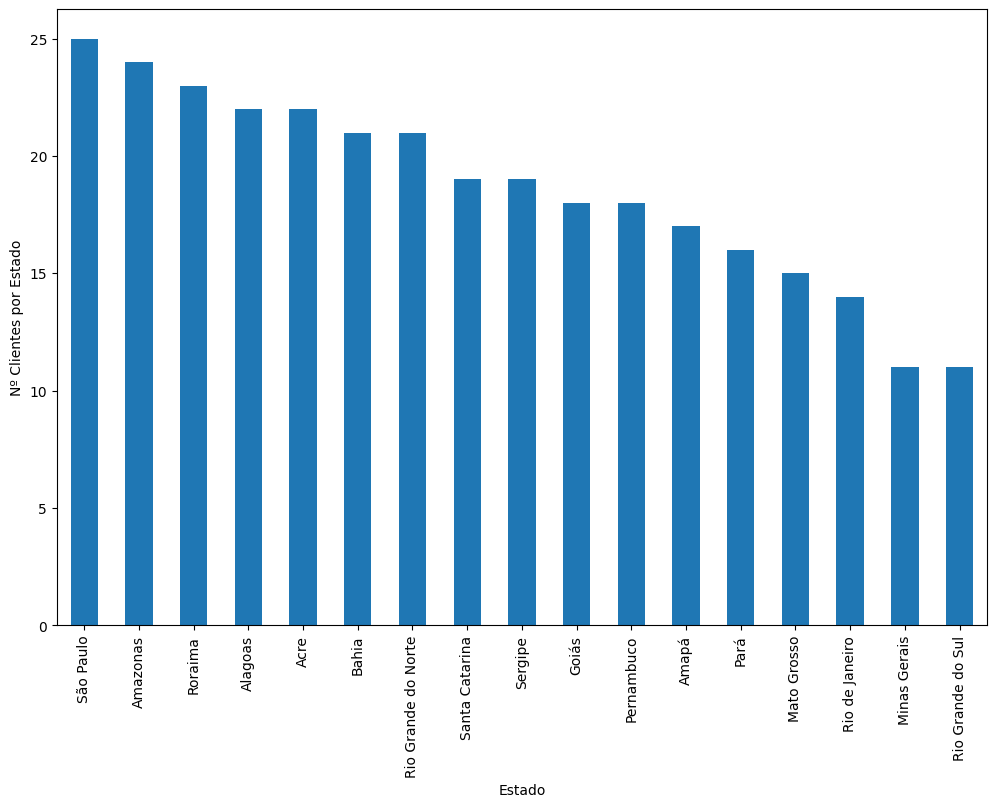

In [49]:
base_cep_cliente.groupby (['Estado']).Estado.size().sort_values(ascending = False).plot.bar(figsize = (12,8), xlabel = 'Estado', ylabel = 'Nº Clientes por Estado')

<Axes: xlabel='Estado', ylabel='Qtde Serviços'>

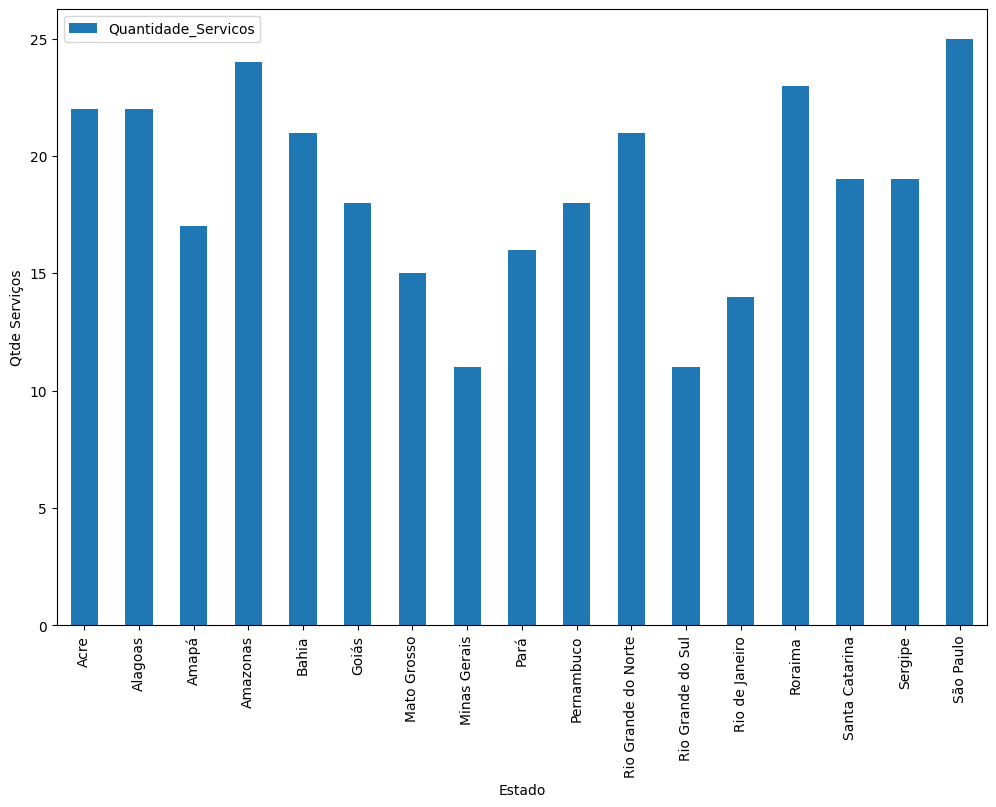

In [50]:
base_cep_cliente.groupby(['Estado']).agg({'Quantidade_Servicos': 'count'}).plot.bar(figsize = (12,8), xlabel = 'Estado', ylabel = 'Qtde Serviços')

<Axes: xlabel='Estado Civil', ylabel='Qtde Funcionários'>

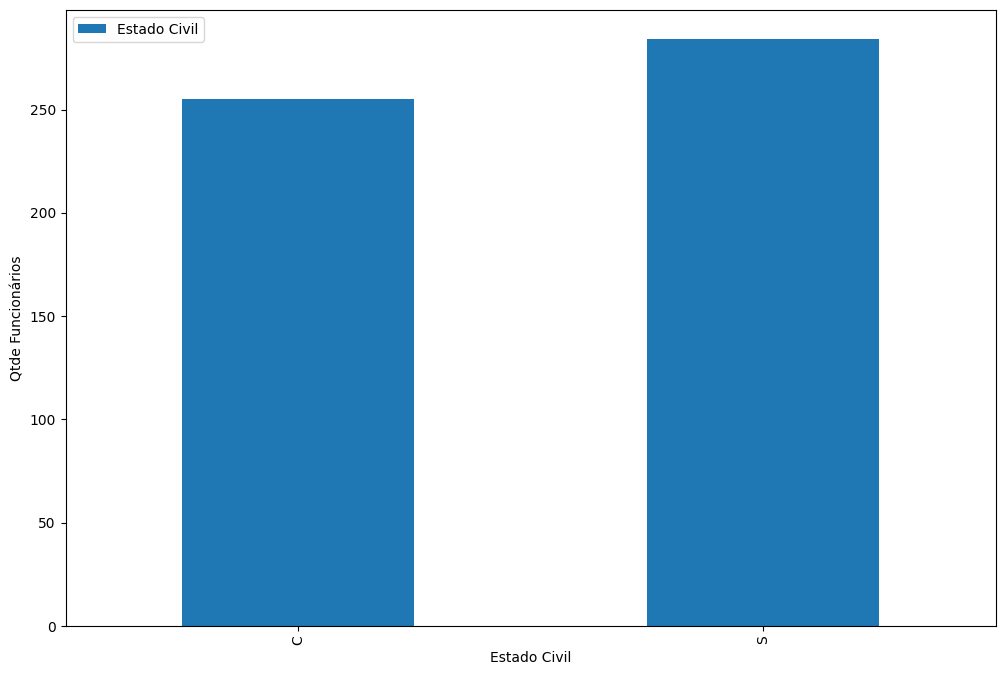

In [51]:
base_funcionarios_tratado.groupby(['Estado Civil']).agg({'Estado Civil': 'count'}).plot.bar(figsize = (12,8), xlabel = 'Estado Civil', ylabel = 'Qtde Funcionários')

<Axes: xlabel='Idade', ylabel='Qtde Funcionários'>

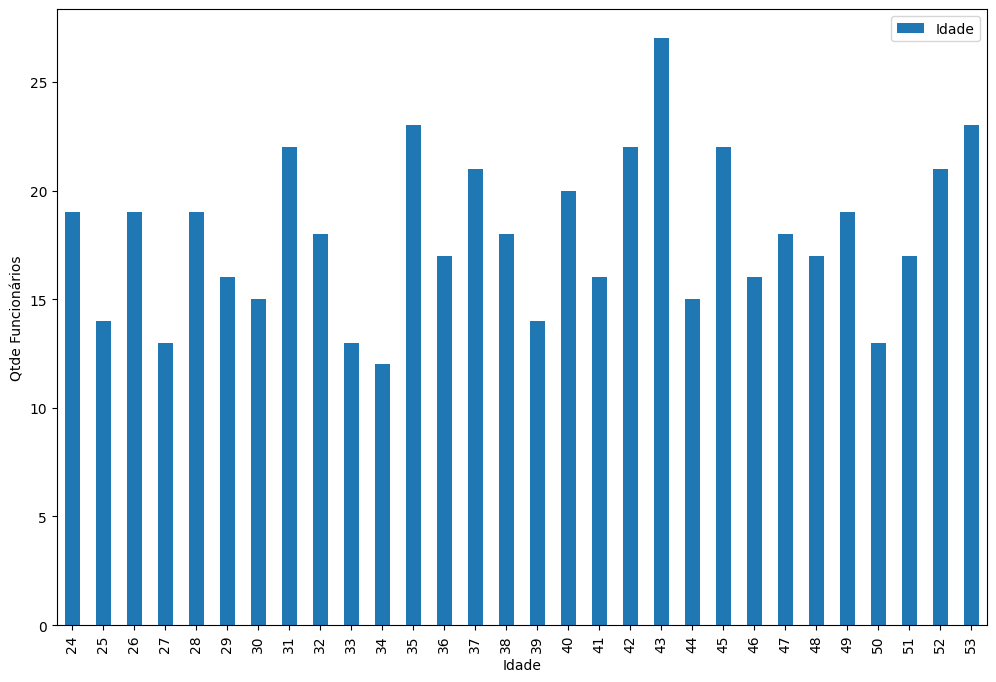

In [52]:
base_funcionarios_tratado.groupby(['Idade']).agg({'Idade': 'count'}).plot.bar(figsize = (12,8), xlabel = 'Idade', ylabel = 'Qtde Funcionários')

<Axes: xlabel='Estado Civil', ylabel='Qtde Férias'>

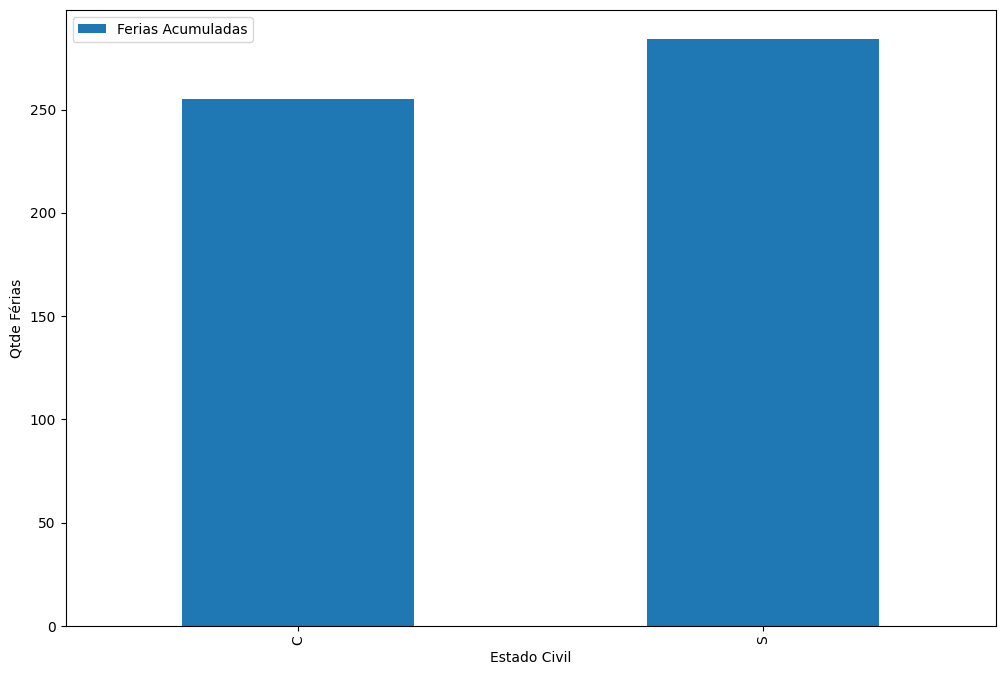

In [53]:
base_funcionarios_tratado.groupby(['Estado Civil']).agg({'Ferias Acumuladas': 'count'}).plot.bar(figsize = (12,8), xlabel = 'Estado Civil', ylabel = 'Qtde Férias')

<Axes: xlabel='Cod Cargo', ylabel='Salário'>

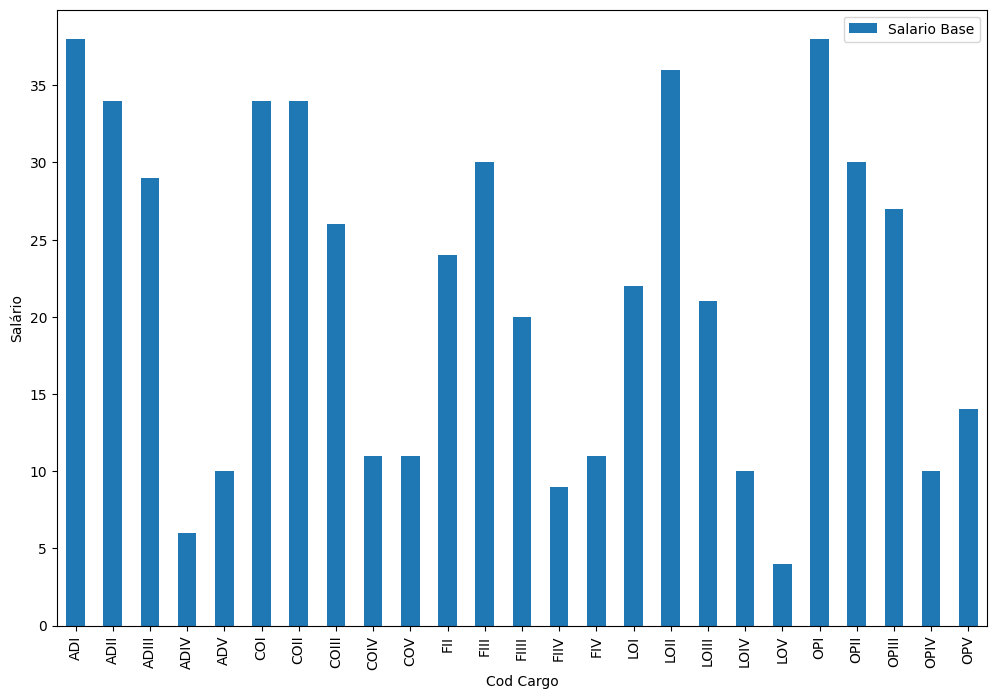

In [54]:
base_funcionarios_tratado.groupby(['Cargo']).agg({'Salario Base': 'count'}).plot.bar(figsize = (12,8), xlabel = 'Cod Cargo', ylabel = 'Salário')